<a href="https://colab.research.google.com/github/turtlespeedv/NETFLIX_GENRE_EARLY/blob/main/NETFLIX_HIREME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:

!pip install kagglehub --quiet

import kagglehub
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay


In [6]:
path = kagglehub.dataset_download("ahmadrazakashif/netflix-streaming-data")
print("Dataset downloaded at:", path)

# Inspect files in the dataset folder
os.listdir(path)

Using Colab cache for faster access to the 'netflix-streaming-data' dataset.
Dataset downloaded at: /kaggle/input/netflix-streaming-data


['netflix_titles.csv']

In [7]:
file = [f for f in os.listdir(path) if f.endswith(".csv")][0]
print("Loading file:", file)

df = pd.read_csv(os.path.join(path, file))
df.head()

Loading file: netflix_titles.csv


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [11]:
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
df.info()

# Check how many unique ratings exist
if 'rating' in df.columns:
    print("\nUnique ratings:", df['rating'].unique())
else:
    raise ValueError("No 'Rating' column found in dataset! Please recheck the dataset structure.")

Shape: (8807, 12)

Columns: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB

Unique ratings: ['PG-13' 'TV-MA' 'PG' 'TV-14' 'TV-PG' 'TV-Y' 'TV-Y7' 'R' 'TV-G' 'G'

In [13]:
df = df.dropna(subset=['description', 'rating'])

# Clean description text
def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', str(text))
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_desc'] = df['description'].apply(clean_text)

# Optional: Filter rare ratings (to simplify)
rating_counts = df['rating'].value_counts()
valid_ratings = rating_counts[rating_counts > 100].index  # keep common ratings only
df = df[df['rating'].isin(valid_ratings)]

print("Remaining ratings:", df['rating'].unique())
print("Cleaned dataset size:", df.shape)

Remaining ratings: ['PG-13' 'TV-MA' 'PG' 'TV-14' 'TV-PG' 'TV-Y' 'TV-Y7' 'R' 'TV-G']
Cleaned dataset size: (8667, 13)


/tmp/ipython-input-3477038175.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_desc'] = df['description'].apply(clean_text)


In [14]:
X = df['clean_desc']
y = df['rating']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train), "| Test size:", len(X_test))

Train size: 6933 | Test size: 1734


In [15]:
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF shape:", X_train_tfidf.shape)

TF-IDF shape: (6933, 5000)


In [16]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

print("\n🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


🎯 Accuracy: 0.4186851211072664

Classification Report:
               precision    recall  f1-score   support

          PG       0.00      0.00      0.00        57
       PG-13       0.00      0.00      0.00        98
           R       0.50      0.04      0.08       160
       TV-14       0.35      0.36      0.36       432
        TV-G       0.00      0.00      0.00        44
       TV-MA       0.44      0.81      0.57       642
       TV-PG       0.31      0.06      0.10       173
        TV-Y       0.90      0.31      0.46        61
       TV-Y7       0.48      0.19      0.28        67

    accuracy                           0.42      1734
   macro avg       0.33      0.20      0.20      1734
weighted avg       0.38      0.42      0.34      1734



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

          PG       0.51      0.62      0.56        29
       PG-13       0.37      0.57      0.45        49
           R       0.46      0.71      0.56        80
       TV-14       0.45      0.44      0.44       216
        TV-G       0.06      0.05      0.05        22
       TV-MA       0.70      0.46      0.56       321
       TV-PG       0.28      0.36      0.31        86
        TV-Y       0.62      0.77      0.69        31
       TV-Y7       0.66      0.76      0.70        33

    accuracy                           0.49       867
   macro avg       0.46      0.53      0.48       867
weighted avg       0.53      0.49      0.50       867



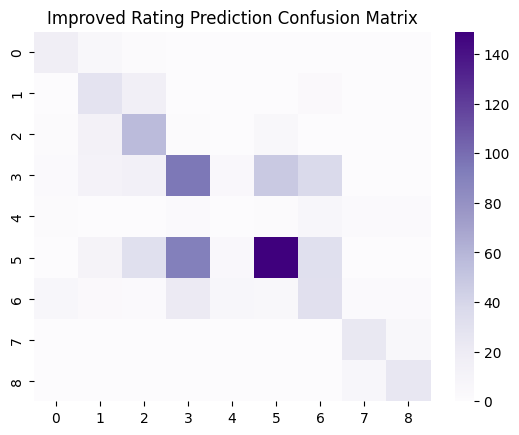

In [28]:
df['text'] = df['type'] + " " + df['listed_in'] + " " + df['description']

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['rating'], test_size=0.1, random_state=42, stratify=df['rating'])

tfidf = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
model = LogisticRegression(max_iter=2000, class_weight='balanced')
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=False, cmap='Purples')
plt.title("Improved Rating Prediction Confusion Matrix")
plt.show()


In [30]:
df['rating'].value_counts()

,count
rating,
TV-MA,3207
TV-14,2160
TV-PG,863
R,799
PG-13,490
TV-Y7,334
TV-Y,307
PG,287
TV-G,220


In [32]:
samples = [
    "A group of teenagers uncover a dark secret in their small town and must fight for survival.",
    "Lovers kill charmingly.",
    "An intense war drama following soldiers behind enemy lines."
]

samples_tfidf = tfidf.transform(samples)
predictions = model.predict(samples_tfidf)

for text, pred in zip(samples, predictions):
    print(f"\n📝 Description: {text}\n🎬 Predicted Rating: {pred}")


📝 Description: A group of teenagers uncover a dark secret in their small town and must fight for survival.
🎬 Predicted Rating: PG-13

📝 Description: Lovers kill charmingly.
🎬 Predicted Rating: R

📝 Description: An intense war drama following soldiers behind enemy lines.
🎬 Predicted Rating: R
